## 課題① Kickstarter Projects
- クラウドファンデイングが成功するか(state)を予測

- 交差検証、ホールドアウト法などで汎化性能を確認する
- 欠測値と異常値を確認し、適切に処理する
- DAY3で学んだアルゴリズムを利用してモデルをつくり、DAY2宿題提出時の精度と比較する
- 交差検証によるパラメータチューニングを行う
- パラメータチューニング後のモデルによって、精度および結果の評価を行う
- その他、精度の向上ができるような処理に取り組み、精度を上げる

### DAY3の学習
- 特徴選択
- 木モデル(決定木、ランダムフォレスト、アダブースト)
- ニューラルネットワーク

### POINT
- 標準化や正規化は、train_test_splitした後に行う。
- 正則化係数やSVMのCなどのハイパーパラメータは、適切な値を探索する。デフォルトをそのまま用いてもうまくいかない。
- グリッドサーチを行うときは、候補値の範囲や間隔が適切かどうかをよく検討する。
- 手法どうしを汎化誤差で比較する場合は、用いるテストデータなどの条件を揃える。
- サンプリングしたデータで学習する場合、まず、全学習データをtrainとtestにわけ、そのtarinの中から1%とか5%を抜き出して学習する。

- 正則化を適用する場合は、必ず標準化を行ってから行う
- 正則化を適用する場合は、alphaを調整する
- rbfを用いるときは、gammaを調整した方が良い
- recallを上げたければ、閾値（ロジスティック回帰の場合は0.5、SVMの場合は0）を下げるという方法もある

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数

from sklearn.model_selection import train_test_split # ホールドアウト法に関する関数
from sklearn.preprocessing import StandardScaler

#from sklearn.feature_selection import RFECV #ステップワイズ法
#from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import StandardScaler, MinMaxScaler

#from sklearn.model_selection import train_test_split, GridSearchCV
#from sklearn.svm import SVC #SVMを計算

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV #埋め込み法

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

### 1. データの読み込み

ks-projects-201801.csvのColumnについて

|No|列名|意味|目的変数|説明変数|メモ|
| ---: | :---| :--- | :---: | :---: | :--- |
|1|ID|id|-|-|分析に不要|
|2|name|プロジェクト名|-|-|-|
|3|category|サブカテゴリ|-|-|-|
|4|main_category|メインカテゴリ|-|-|-|
|5|currency|通貨|-|-|-|
|6|deadline|クラウドファンディングの締切日|-|-|deadline～launchedの期間(日数)を計算|
|7|goal|目標額|-|-|usd_goal_realの方が通貨が統一されているため使用しない|
|8|launched|開始日時|-|-|deadline～launchedの期間(日数)を計算|
|9|pledged|出資金額。最終的に集まった金額|-|×|※予測に使えない|
|10|state|状態|〇|-|-|
|11|backers|出資者数。出資した人数|-|×|※予測に使えない|
|12|country|国|-|-|大陸別に変換|
|13|usd pledged|米ドルでの出資金額(KSによる変換)|-|×|※予測に使えない|
|14|usd_pledged_real|米ドルでの出資金額(fixer.io apiによる変換)|-|×|※予測に使えない|
|15|usd_goal_real|米ドルでの目標額|-|-|-|

In [2]:
df_kp = pd.read_csv("./ks-projects-201801.csv")

display(df_kp.head())
#統計量をすべて出力
#平均=mean
#std=標準偏差
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [3]:
#欠損値チェック
df_kp.isnull().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

In [4]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [5]:
#categoryの要素の個数を表示
df_kp.category.value_counts()

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [6]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

#### stateの値
- failed：失敗
- successful：成功
- canceled：キャンセル
- undefined：未定義
- live：実行中
- suspended：一時停止

### 2.stateが 成功(successful) 又は 失敗(failed) のデータのみを取得

In [7]:
df_kp=df_kp[(df_kp.state == 'failed') | (df_kp.state == 'successful')]
display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,successful,224,US,52375.0,52375.0,50000.00


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05
mean,1.074271e+09,4.425157e+04,1.058400e+04,116.381581,7.684569e+03,9.943461e+03,4.151000e+04
std,6.191924e+08,1.117917e+06,1.015917e+05,965.427268,8.320938e+04,9.673293e+04,1.108930e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.371725e+08,2.000000e+03,5.000000e+01,2.000000,2.500000e+01,5.000000e+01,2.000000e+03
50%,1.074573e+09,5.000000e+03,7.820000e+02,15.000000,5.020000e+02,7.880000e+02,5.000000e+03
75%,1.609844e+09,1.500000e+04,4.657000e+03,63.000000,3.421000e+03,4.608000e+03,1.500000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [8]:
#stateの要素の個数を表示
df_kp.state.value_counts()

failed        197719
successful    133956
Name: state, dtype: int64

### 3.stateの値を1(成功)、0(失敗)に変更

In [9]:
#stateがsuccessful(成功)の場合、stateに1を設定
#stateがfailed(失敗)の場合、stateに0を設定
df_kp.loc[df_kp.state=='successful',["state"]]=1
df_kp.loc[df_kp.state=='failed',["state"]]=0
display(df_kp.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00


### 4.クラウドファンディングの期間（日数）を計算
- deadline(締切日)～launched(開始日時)の期間

In [10]:
#deadline(締切日)とlaunched(開始日時)を時刻型に変換
df_kp['deadline'] = pd.to_datetime(df_kp['deadline'], format='%Y-%m-%d %H:%M:%S')
df_kp['launched'] = pd.to_datetime(df_kp['launched'], format='%Y-%m-%d %H:%M:%S')

#クラウドファンディングの期間（日数）を計算
df_kp['period']=(df_kp['deadline'] - df_kp['launched']).dt.days

display(df_kp.head())
display(df_kp.describe())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,period
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,0,0,GB,0.0,0.0,1533.95,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,0,15,US,100.0,2421.0,30000.00,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,0,3,US,220.0,220.0,45000.00,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,0,1,US,1.0,1.0,5000.00,29
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.0,1,224,US,52375.0,52375.0,50000.00,34


,ID,goal,pledged,state,backers,usd pledged,usd_pledged_real,usd_goal_real,period
count,3.316750e+05,3.316750e+05,3.316750e+05,331675.000000,331675.000000,3.314650e+05,3.316750e+05,3.316750e+05,331675.000000
mean,1.074271e+09,4.425157e+04,1.058400e+04,0.403877,116.381581,7.684569e+03,9.943461e+03,4.151000e+04,32.954902
std,6.191924e+08,1.117917e+06,1.015917e+05,0.490674,965.427268,8.320938e+04,9.673293e+04,1.108930e+06,12.713329
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000
25%,5.371725e+08,2.000000e+03,5.000000e+01,0.000000,2.000000,2.500000e+01,5.000000e+01,2.000000e+03,29.000000
50%,1.074573e+09,5.000000e+03,7.820000e+02,0.000000,15.000000,5.020000e+02,7.880000e+02,5.000000e+03,29.000000
75%,1.609844e+09,1.500000e+04,4.657000e+03,1.000000,63.000000,3.421000e+03,4.608000e+03,1.500000e+04,35.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,1.000000,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,91.000000


### categoryの特徴量をチェック

In [11]:
df_tmp = df_kp.groupby('category')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
category,,
3D Printing,0.573944,0.426056
Academic,0.758044,0.241956
Accessories,0.608394,0.391606
Action,0.827697,0.172303
Animals,0.724891,0.275109
Animation,0.691821,0.308179
Anthologies,0.293080,0.706920
Apparel,0.770678,0.229322
Apps,0.928504,0.071496


state,0,1
count,159.000000,159.000000
mean,0.615441,0.384559
std,0.154968,0.154968
min,0.181818,0.071496
25%,0.507175,0.261612
50%,0.623955,0.376045
75%,0.738388,0.492825
max,0.928504,0.818182


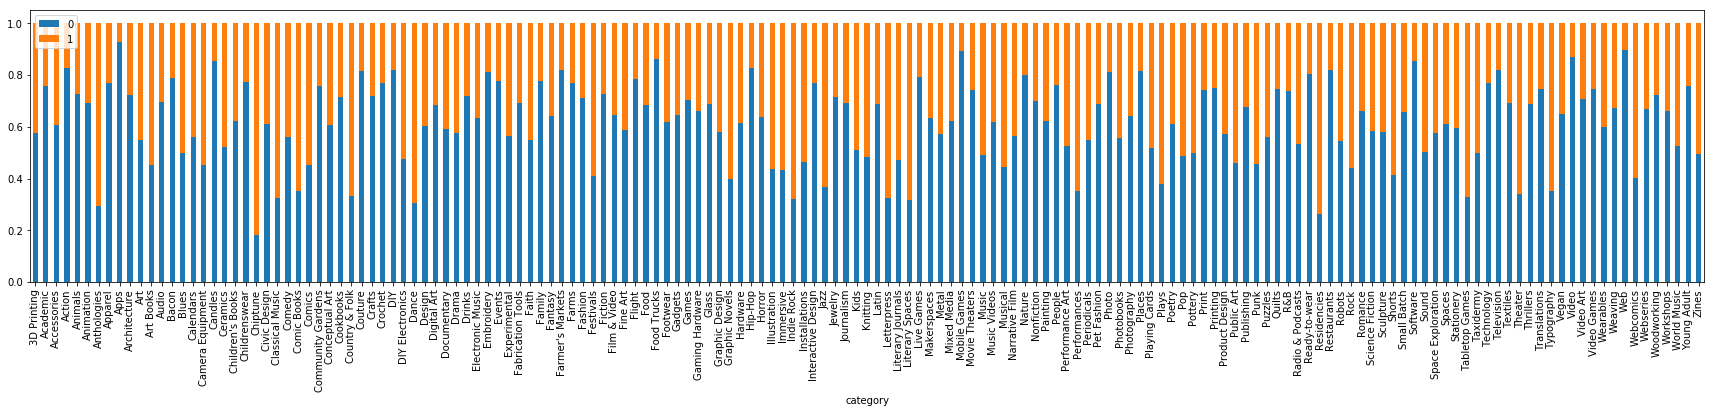

In [12]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

- categoryによって成功率のばらつき（7.15％～81.8％）があるため、説明変数に追加する

### main_categoryの特徴量をチェック

In [13]:
df_tmp = df_kp.groupby('main_category')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
main_category,,
Art,0.551110,0.448890
Comics,0.408585,0.591415
Crafts,0.729470,0.270530
Dance,0.345648,0.654352
Design,0.584056,0.415944
Fashion,0.717168,0.282832
Film & Video,0.582094,0.417906
Food,0.724086,0.275914
Games,0.561095,0.438905


state,0,1
count,15.000000,15.000000
mean,0.591257,0.408743
std,0.141456,0.141456
min,0.345648,0.237856
25%,0.512252,0.279373
50%,0.584056,0.415944
75%,0.720627,0.487748
max,0.762144,0.654352


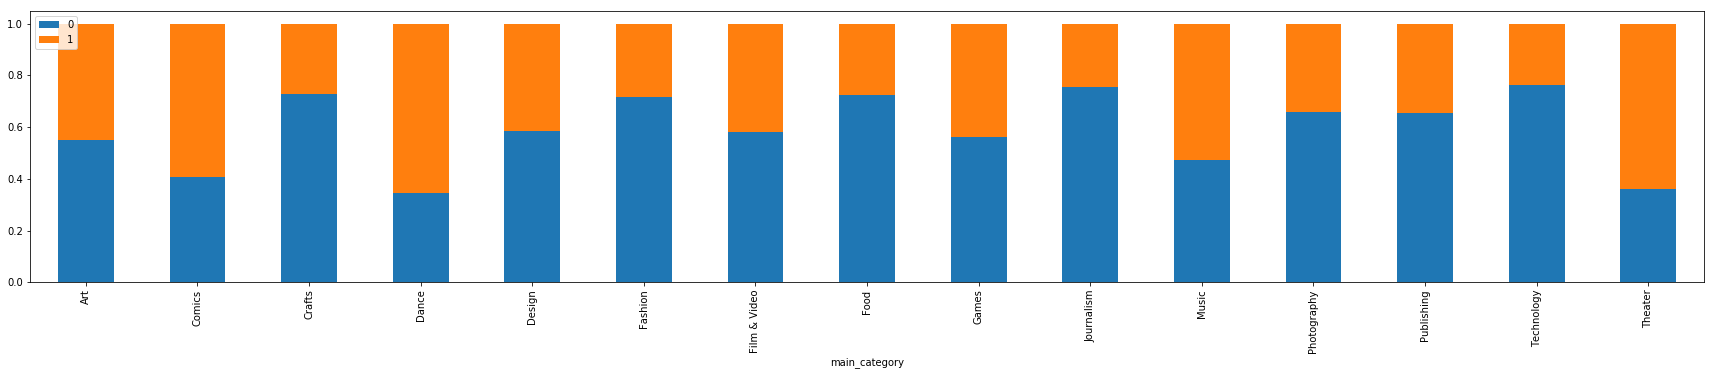

In [14]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

- main_categoryによって成功率のばらつき（23.8％～65.4％）があるため、説明変数に追加する

### currencyの特徴量をチェック

In [15]:
df_tmp = df_kp.groupby('currency')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
currency,,
AUD,0.696269,0.303731
CAD,0.665697,0.334303
CHF,0.713190,0.286810
DKK,0.610334,0.389666
EUR,0.730004,0.269996
GBP,0.590141,0.409859
HKD,0.547170,0.452830
JPY,0.695652,0.304348
MXN,0.719348,0.280652


state,0,1
count,14.000000,14.000000
mean,0.656402,0.343598
std,0.059778,0.059778
min,0.547170,0.269996
25%,0.608531,0.291040
50%,0.664305,0.335695
75%,0.708960,0.391469
max,0.730004,0.452830


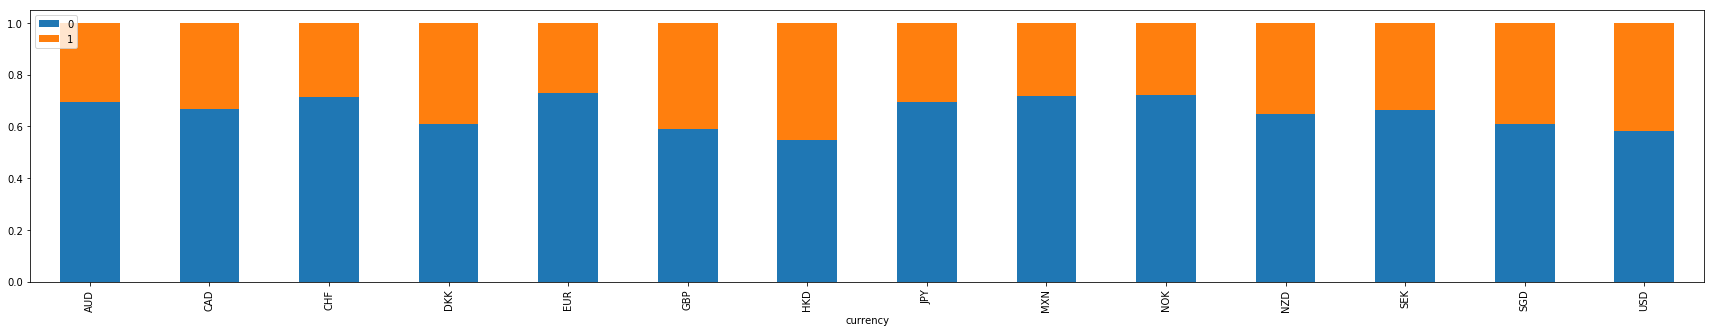

In [16]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

- currencyによって成功率のばらつき（27.0％～45.3％）があるため、説明変数に追加する

### countryの特徴量をチェック

In [17]:
df_tmp = df_kp.groupby('country')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
country,,
AT,0.779381,0.220619
AU,0.696191,0.303809
BE,0.709369,0.290631
CA,0.665804,0.334196
CH,0.713190,0.286810
DE,0.727299,0.272701
DK,0.611231,0.388769
ES,0.737320,0.262680
FR,0.639683,0.360317


state,0,1
count,23.000000,23.000000
mean,0.672902,0.327098
std,0.074921,0.074921
min,0.500000,0.185310
25%,0.625457,0.279501
50%,0.695652,0.304348
75%,0.720499,0.374543
max,0.814690,0.500000


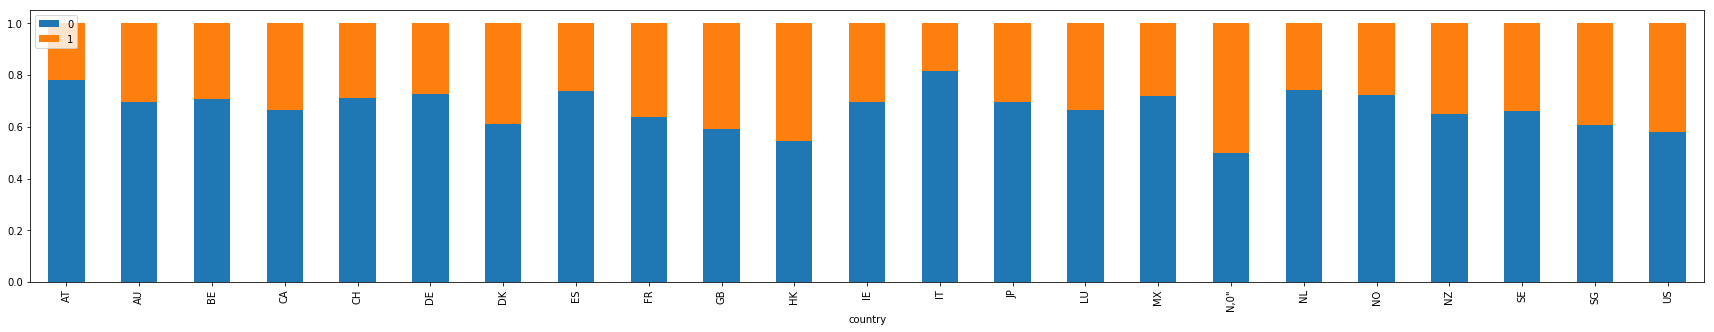

In [18]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

- countryによって成功率のばらつき（18.5％～50.0％）があるため、説明変数に追加する
- 50.0％のデータはおかしい？

### period（クラウドファンディングの期間（日数））の特徴量をチェック

In [19]:
df_tmp = df_kp.groupby('period')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
period,,
0,0.619565,0.380435
1,0.573643,0.426357
2,0.639175,0.360825
3,0.576531,0.423469
4,0.566964,0.433036
5,0.516340,0.483660
6,0.510353,0.489647
7,0.429542,0.570458
8,0.416667,0.583333


state,0,1
count,92.000000,92.000000
mean,0.545059,0.454941
std,0.091869,0.091869
min,0.375457,0.222496
25%,0.474454,0.397233
50%,0.539917,0.460083
75%,0.602767,0.525546
max,0.777504,0.624543


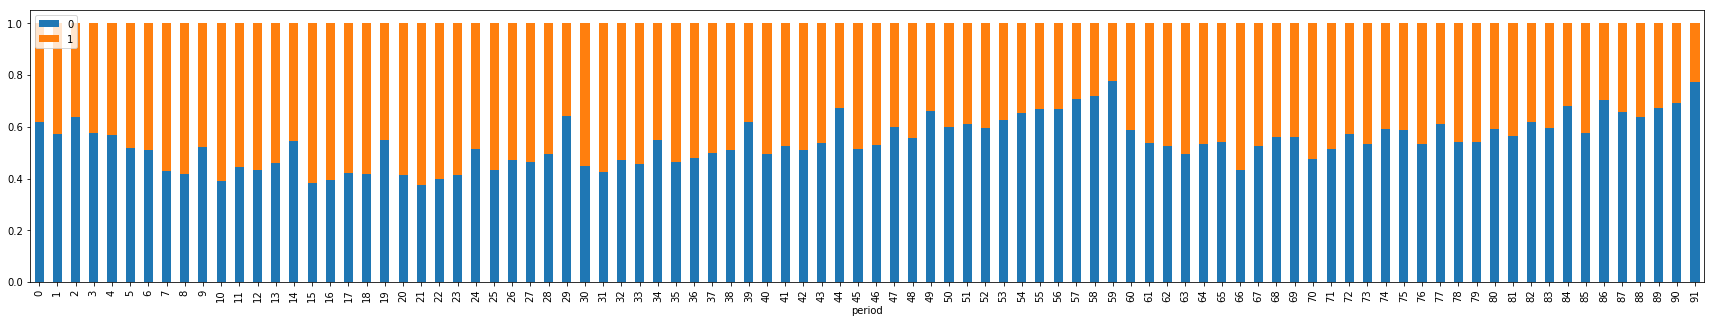

In [20]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

- periodによって成功率のばらつき（22.2％～62.5％）があるため、説明変数に追加する

### 5.不要な列を除く
- 不要なデータ：ID
- 予測に使えない：pledged, backers, usd pledged, usd_pledged_real
- goal：usd_goal_realと重複しているため
- deadline、launched：日数に変換したため

- Day1との違い：name、categoryを削除しない

In [21]:
#不要列の削除
df_kp=df_kp.drop(columns=['ID', 'deadline', 'goal', 'launched', 'pledged', 'backers' ,'usd pledged', 'usd_pledged_real'])
display(df_kp.head())
display(df_kp.describe())

,name,category,main_category,currency,state,country,usd_goal_real,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,GB,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,US,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,0,US,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,US,5000.00,29
5,Monarch Espresso Bar,Restaurants,Food,USD,1,US,50000.00,34


,state,usd_goal_real,period
count,331675.000000,3.316750e+05,331675.000000
mean,0.403877,4.151000e+04,32.954902
std,0.490674,1.108930e+06,12.713329
min,0.000000,1.000000e-02,0.000000
25%,0.000000,2.000000e+03,29.000000
50%,0.000000,5.000000e+03,29.000000
75%,1.000000,1.500000e+04,35.000000
max,1.000000,1.663614e+08,91.000000


In [22]:
#欠損値チェック
df_kp.isnull().sum()

name             3
category         0
main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

In [23]:
df_kp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 8 columns):
name             331672 non-null object
category         331675 non-null object
main_category    331675 non-null object
currency         331675 non-null object
state            331675 non-null int64
country          331675 non-null object
usd_goal_real    331675 non-null float64
period           331675 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 22.8+ MB


In [24]:
#categoryの要素の個数を表示
df_kp.category.value_counts()

Product Design       18680
Documentary          14523
Music                12633
Tabletop Games       11744
Shorts               11394
Food                 10416
Video Games           9328
Film & Video          8624
Fiction               8108
Fashion               7529
Art                   7486
Nonfiction            7414
Theater               6684
Rock                  6246
Children's Books      6198
Apparel               6166
Technology            5726
Indie Rock            5329
Apps                  5287
Photography           5246
Webseries             5148
Publishing            5052
Narrative Film        4618
Comics                4581
Web                   4309
Country & Folk        4213
Crafts                4152
Design                3547
Hip-Hop               3459
Hardware              3115
                     ...  
Blues                  234
Animals                229
Couture                227
Fabrication Tools      215
Makerspaces            208
Movie Theaters         201
P

In [25]:
#main_categoryの要素の個数を表示
df_kp.main_category.value_counts()

Film & Video    56527
Music           45949
Publishing      35445
Games           28521
Technology      27050
Art             25641
Design          25364
Food            22054
Fashion         19775
Theater         10242
Comics           9878
Photography      9689
Crafts           7818
Journalism       4149
Dance            3573
Name: main_category, dtype: int64

In [26]:
#currencyの要素の個数を表示
df_kp.currency.value_counts()

USD    261511
GBP     29476
EUR     14378
CAD     12375
AUD      6621
SEK      1510
MXN      1411
NZD      1274
DKK       929
CHF       652
NOK       584
HKD       477
SGD       454
JPY        23
Name: currency, dtype: int64

In [27]:
#countryの要素の個数を表示
df_kp.country.value_counts()

US      261360
GB       29454
CA       12370
AU        6616
DE        3436
FR        2520
NL        2411
IT        2369
ES        1873
SE        1509
MX        1411
NZ        1274
DK         926
IE         683
CH         652
NO         582
BE         523
AT         485
HK         477
SG         454
N,0"       210
LU          57
JP          23
Name: country, dtype: int64

### 6.countryの「N,0"」を「NO」に変換

In [28]:
#CSVデータを確認すると「N,0"」のデータは「"(ダブルクォーテーション)」の出力が失敗していると思われるため、
#countryの「N,0"」を「NO（ノルウェー）」と判断して「NO」に変換
df_kp.loc[df_kp.country=='N,0"',["country"]]='NO'

#countryの要素の個数を表示
df_kp.country.value_counts()

US    261360
GB     29454
CA     12370
AU      6616
DE      3436
FR      2520
NL      2411
IT      2369
ES      1873
SE      1509
MX      1411
NZ      1274
DK       926
NO       792
IE       683
CH       652
BE       523
AT       485
HK       477
SG       454
LU        57
JP        23
Name: country, dtype: int64

### 7.countryを大陸別に変換
- 北アメリカ：North America
- ヨーロッパ：Europe
- オセアニア：Oceania
- アジア：Asia

|データ|国名|大陸名に変換|
| :--- | :---| :--- |
|US|アメリカ|North America|
|GB|イギリス|Europe|
|CA|カナダ|North America|
|AU|オーストラリア|Oceania|
|DE|ドイツ|Europe|
|FR|フランス|Europe|
|NL|オランダ|Europe|
|IT|イタリア|Europe|
|ES|スペイン|Europe|
|SE|スウェーデン|Europe|
|MX|メキシコ|North America|
|NZ|ニュージーランド|Oceania|
|DK|デンマーク|Europe|
|IE|アイルランド|Europe|
|CH|スイス|Europe|
|NO|ノルウェー|Europe|
|BE|ベルギー|Europe|
|AT|オーストリア|Europe|
|HK|香港|Asia|
|SG|シンガポール|Asia|
|LU|ルクセンブルク|Europe|
|JP|日本|Asia|

In [29]:
#countryを大陸別に変換
df_kp.loc[df_kp.country=='US'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='GB'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CA'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='AU'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='FR'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NL'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='ES'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='SE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='MX'  ,["country"]]='North_America'
df_kp.loc[df_kp.country=='NZ'  ,["country"]]='Oceania'
df_kp.loc[df_kp.country=='DK'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='IE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='CH'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='NO'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='BE'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='AT'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='HK'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='SG'  ,["country"]]='Asia'
df_kp.loc[df_kp.country=='N,0"',["country"]]='Europe'
df_kp.loc[df_kp.country=='LU'  ,["country"]]='Europe'
df_kp.loc[df_kp.country=='JP'  ,["country"]]='Asia'

display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34


In [30]:
#countryの要素の個数を表示
df_kp.country.value_counts()

North_America    275141
Europe            47690
Oceania            7890
Asia                954
Name: country, dtype: int64

### 8.nameの欠損値に空白を設定

In [31]:
#nameの欠損値に空白を設定
df_kp.name = df_kp.name.fillna('')
df_kp.isnull().sum()

name             0
category         0
main_category    0
currency         0
state            0
country          0
usd_goal_real    0
period           0
dtype: int64

### 9.nameの単語数を集計

In [32]:
#nameの単語数を集計して、列に追加
df_kp["name_wordCnt"] = df_kp.name.str.split().apply(len)
display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3


### 10.nameの文字数を集計

In [33]:
#nameの文字数を集計して、列に追加
df_kp["name_len"] = df_kp.name.str.len()
display(df_kp.head())

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8,45
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7,49
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3,20


### name_wordCnt（nameの単語数）の特徴量をチェック

In [34]:
df_tmp = df_kp.groupby('name_wordCnt')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
name_wordCnt,,
0,1.000000,0.000000
1,0.703684,0.296316
2,0.699720,0.300280
3,0.673187,0.326813
4,0.618848,0.381152
5,0.581343,0.418657
6,0.566328,0.433672
7,0.545313,0.454687
8,0.540153,0.459847


state,0,1
count,24.000000,24.000000
mean,0.629214,0.370786
std,0.213453,0.213453
min,0.000000,0.000000
25%,0.539921,0.320180
50%,0.568878,0.431122
75%,0.679820,0.460079
max,1.000000,1.000000


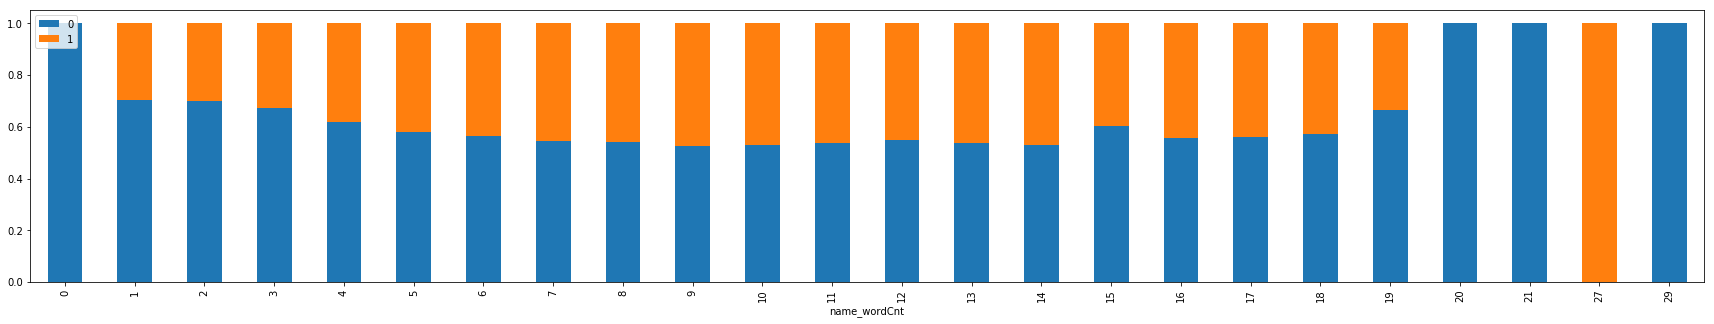

In [35]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

### name_len（nameの文字数）の特徴量をチェック

In [36]:
df_tmp = df_kp.groupby('name_len')
df_tmp = df_tmp['state'].value_counts(normalize=True).unstack(fill_value=0)
display(df_tmp)
df_tmp.describe()

state,0,1
name_len,,
0,1.000000,0.000000
1,0.857143,0.142857
2,0.710526,0.289474
3,0.615385,0.384615
4,0.601675,0.398325
5,0.653239,0.346761
6,0.671129,0.328871
7,0.678121,0.321879
8,0.693679,0.306321


state,0,1
count,86.000000,86.000000
mean,0.586814,0.413186
std,0.090088,0.090088
min,0.326531,0.000000
25%,0.540544,0.376291
50%,0.572792,0.427208
75%,0.623709,0.459456
max,1.000000,0.673469


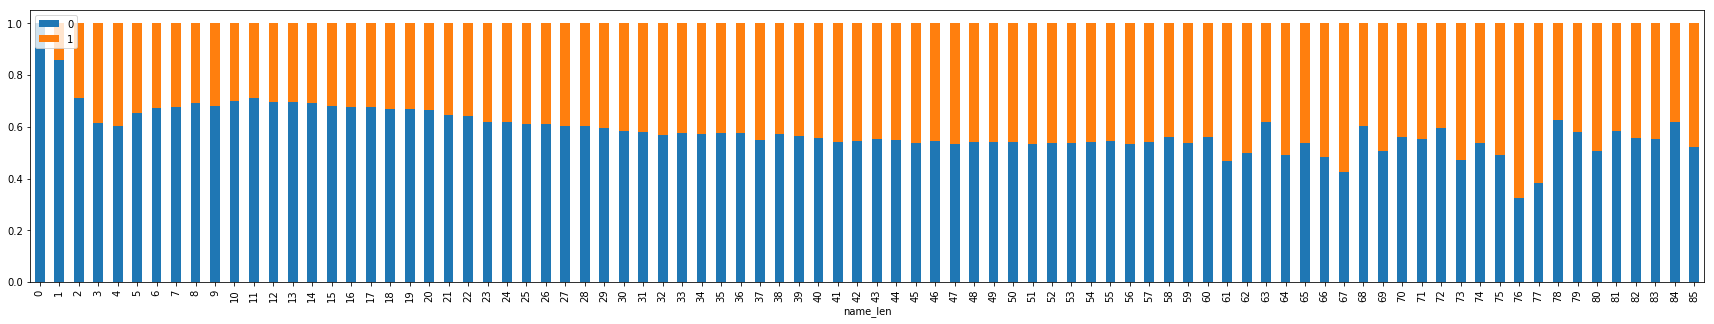

In [37]:
df_tmp.plot.bar(stacked=True, figsize=(30,5))
plt.legend(loc='upper left')
plt.show()

## とりあえず文字データを数値に置き換えて、グラフ作成
### 11.文字データの値を数値に変換

In [38]:
from sklearn.preprocessing import LabelEncoder

#LabelEncoderのインスタンスを生成
le = LabelEncoder()

#df_kpをコピーして、df_kp2を作成
df_kp2=df_kp.copy()

#categoryを数値に変換
le = le.fit(df_kp2.category)
df_kp2.category = le.transform(df_kp2.category)

#main_categoryを数値に変換
le = le.fit(df_kp2.main_category)
df_kp2.main_category = le.transform(df_kp2.main_category)

#currencyを数値に変換
le = le.fit(df_kp2.currency)
df_kp2.currency = le.transform(df_kp2.currency)

#countryを数値に変換
le = le.fit(df_kp2.country)
df_kp2.country = le.transform(df_kp2.country)

display(df_kp2.head())
df_kp2.describe()

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
0,The Songs of Adelaide & Abullah,108,12,5,0,1,1533.95,58,6,31
1,Greeting From Earth: ZGAC Arts Capsule For ET,93,6,13,0,2,30000.00,59,8,45
2,Where is Hank?,93,6,13,0,2,45000.00,44,3,14
3,ToshiCapital Rekordz Needs Help to Complete Album,90,10,13,0,2,5000.00,29,7,49
5,Monarch Espresso Bar,123,7,13,1,2,50000.00,34,3,20


,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len
count,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,3.316750e+05,331675.000000,331675.000000,331675.000000
mean,80.292557,7.483410,11.081227,0.403877,1.874250,4.151000e+04,32.954902,5.630976,34.220026
std,45.069033,3.931466,3.878572,0.490674,0.404062,1.108930e+06,12.713329,2.757369,15.961762
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e-02,0.000000,0.000000,0.000000
25%,39.000000,5.000000,13.000000,0.000000,2.000000,2.000000e+03,29.000000,3.000000,21.000000
50%,85.000000,7.000000,13.000000,0.000000,2.000000,5.000000e+03,29.000000,5.000000,33.000000
75%,119.000000,10.000000,13.000000,1.000000,2.000000,1.500000e+04,35.000000,8.000000,48.000000
max,158.000000,14.000000,13.000000,1.000000,3.000000,1.663614e+08,91.000000,29.000000,85.000000


In [39]:
df_kp2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 10 columns):
name             331675 non-null object
category         331675 non-null int32
main_category    331675 non-null int32
currency         331675 non-null int32
state            331675 non-null int64
country          331675 non-null int32
usd_goal_real    331675 non-null float64
period           331675 non-null int64
name_wordCnt     331675 non-null int64
name_len         331675 non-null int64
dtypes: float64(1), int32(4), int64(4), object(1)
memory usage: 22.8+ MB


### 12.グラフを作成

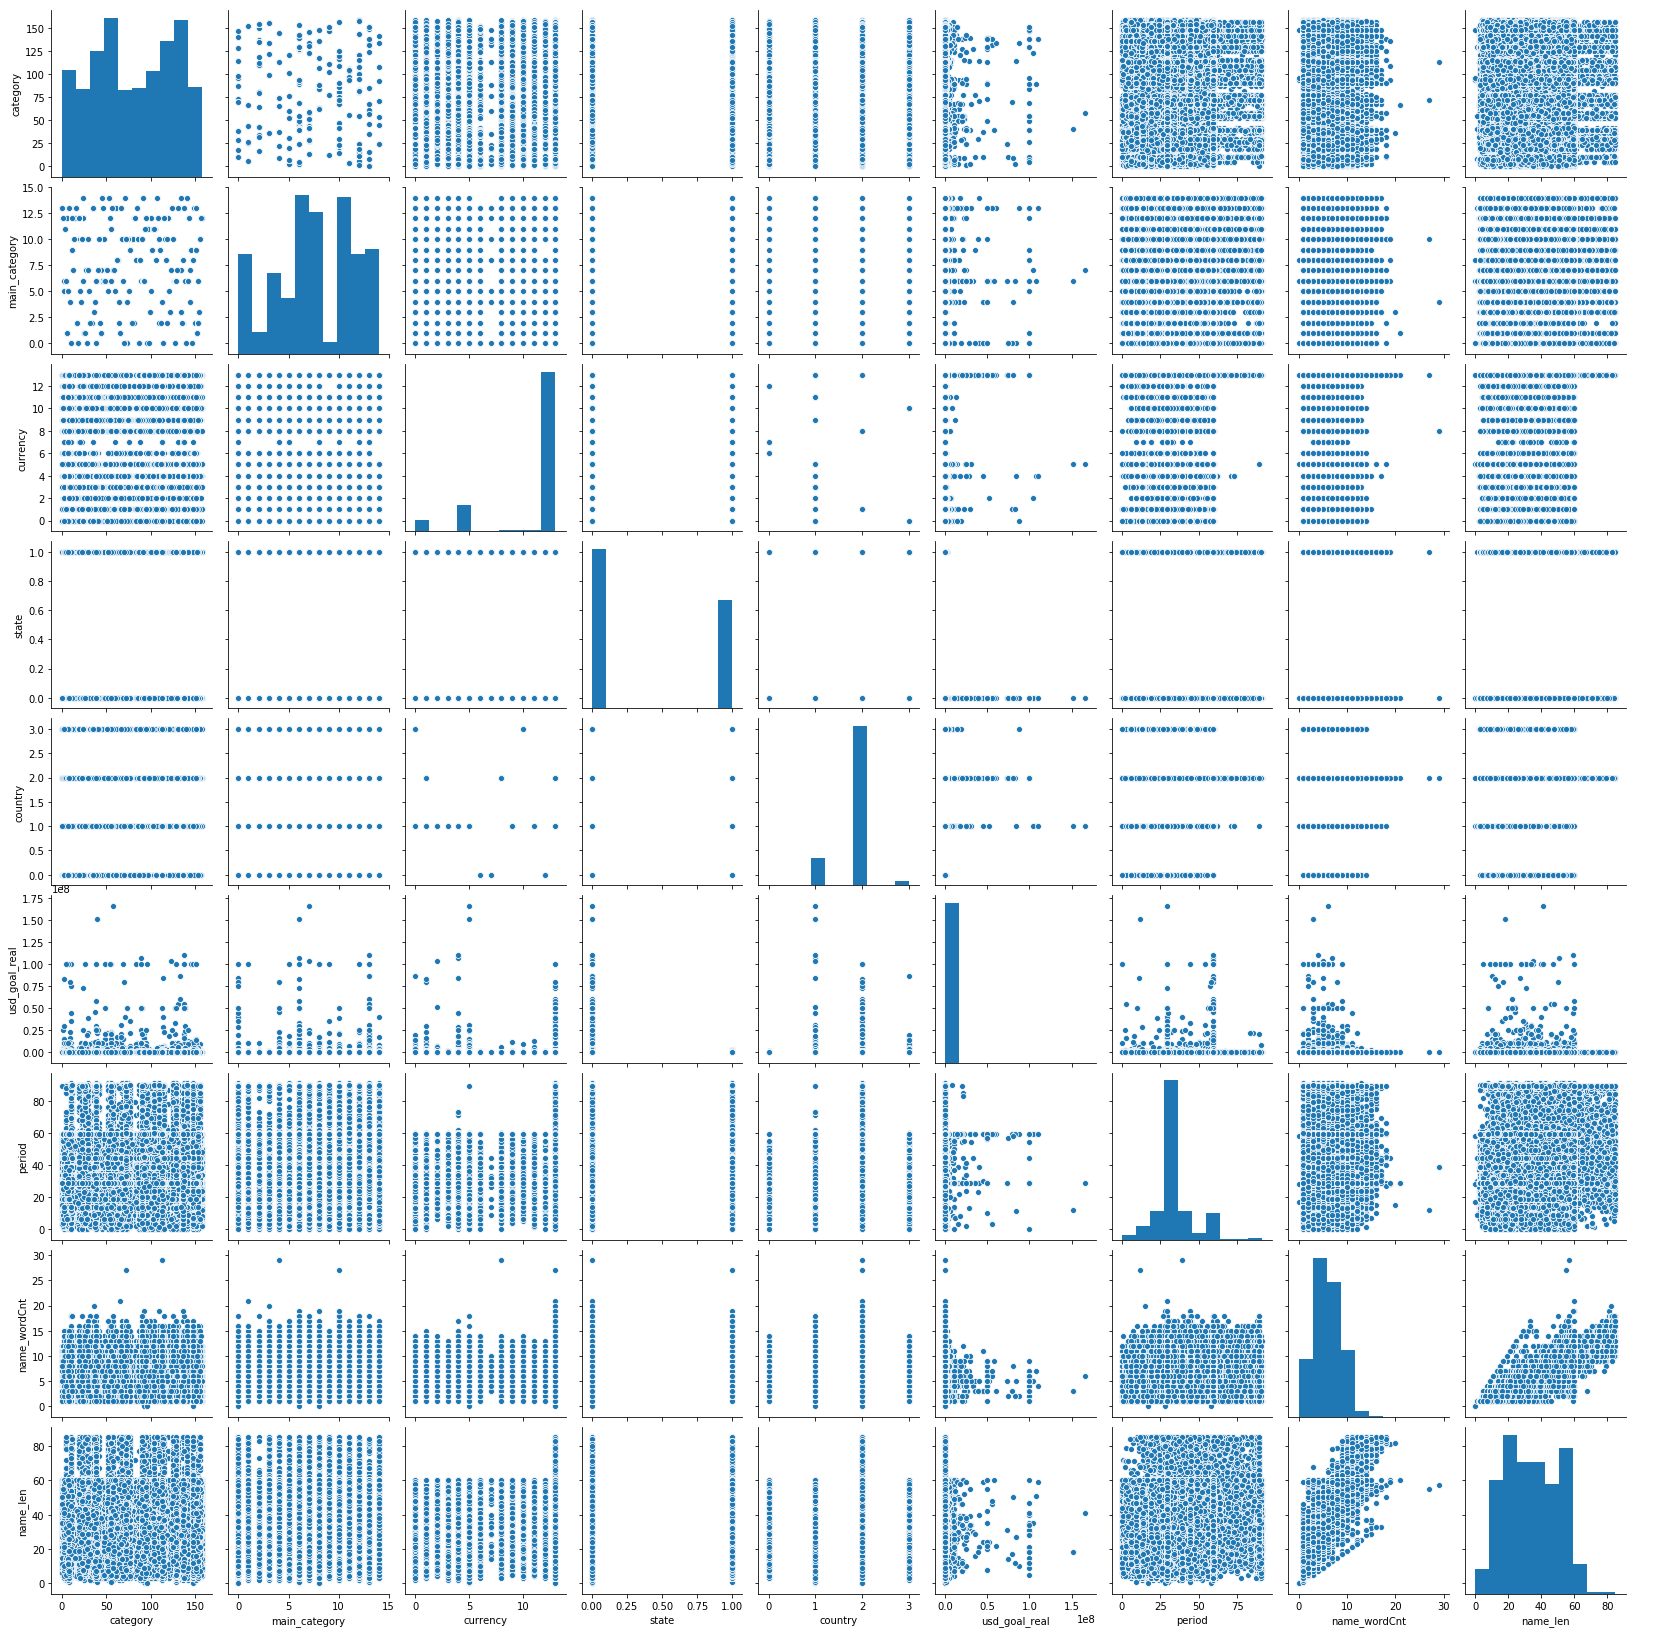

In [40]:
#散布図行列　ヒストグラムと散布図を全てのデータで表示
sns.pairplot(df_kp2[["category","main_category","currency","state","country","usd_goal_real","period","name_wordCnt","name_len"]])

- 散布図行列より、stateと相関がありそうなのは category, usd_goal_real, period, name_wordCnt(nameの単語数), name_len(nameの文字数)？
- period(クラウドファンディングの日数)のヒストグラムより、日数が長いデータ（右端）に外れ値がありそう？

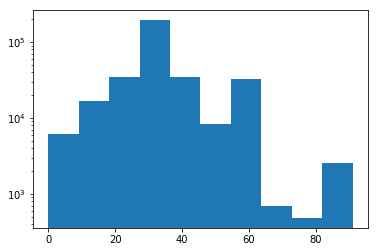

In [41]:
# period(クラウドファンディングの日数)のヒストグラムを作成
plt.hist(df_kp2.period,log=True)
plt.show()

(2311,)

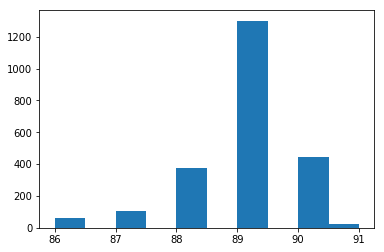

357       86
673       89
895       89
1034      89
1059      89
1205      89
1268      89
1910      89
1966      90
2005      90
2076      89
2354      90
2364      88
2503      90
3000      89
3255      89
3434      89
3471      86
3541      89
3784      88
4073      86
4094      89
4398      90
4606      88
4800      88
4844      89
4870      89
5151      90
5698      89
5935      87
          ..
374237    86
374268    90
374454    89
374524    90
374531    86
374626    90
374631    89
374679    89
375047    90
375402    89
375457    89
375463    89
375559    89
376023    88
376088    89
376144    89
376211    89
376233    89
376298    89
376365    89
376476    90
376668    88
377115    89
377187    90
377241    89
378111    89
378192    89
378552    89
378595    90
378608    89
Name: period, Length: 2311, dtype: int64

In [42]:
#日数が85より大きいデータをチェック
df_tmp = df_kp2['period'][df_kp2['period']>85]
#件数
display(df_tmp.shape)
#ヒストグラムを描画
plt.hist(df_tmp)
plt.show()
#データ表示
display(df_tmp)

- period(クラウドファンディングの日数)は1か月(30)、2カ月(60)、3カ月(90)あたりで件数が増えているため、90日あたりでデータ数が増えているのは問題ない。

## 文字データをダミー変数に置き換えて、モデル作成
### 13.文字データをダミー変数に置き換え
- Day1～Day2との違い：categoryをダミー変数に置き換えて、categoryも説明変数に含めて学習する

In [43]:
#以下のpd.get_dummies(df_kp)を実行するとメモリーエラーになったため、1列ずつダミー変数に置き換える
#df_kp=pd.get_dummies(df_kp)

#categoryをダミー変数に置き換える
df_kp_category=pd.get_dummies(df_kp.category,prefix="category")

#main_categoryをダミー変数に置き換える
df_kp_main_category=pd.get_dummies(df_kp.main_category,prefix="main_category")

#currencyをダミー変数に置き換える
df_kp_currency=pd.get_dummies(df_kp.currency,prefix="currency")

#countryをダミー変数に置き換える
df_kp_country=pd.get_dummies(df_kp.country,prefix="country")

In [44]:
#categoryのダミー変数
display(df_kp_category.head())

,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,category_Animation,category_Anthologies,category_Apparel,category_Apps,category_Architecture,...,category_Wearables,category_Weaving,category_Web,category_Webcomics,category_Webseries,category_Woodworking,category_Workshops,category_World Music,category_Young Adult,category_Zines
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#main_categoryのダミー変数
display(df_kp_main_category.head())

,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,main_category_Design,main_category_Fashion,main_category_Film & Video,main_category_Food,main_category_Games,main_category_Journalism,main_category_Music,main_category_Photography,main_category_Publishing,main_category_Technology,main_category_Theater
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [46]:
#currencyのダミー変数
display(df_kp_currency.head())

,currency_AUD,currency_CAD,currency_CHF,currency_DKK,currency_EUR,currency_GBP,currency_HKD,currency_JPY,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [47]:
#countryのダミー変数
display(df_kp_country.head())

,country_Asia,country_Europe,country_North_America,country_Oceania
0,0,1,0,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
5,0,0,1,0


In [48]:
#ダミー変数で作成したDataFrameを結合
df_kp3=pd.concat([df_kp,  df_kp_category], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_main_category], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_currency], axis=1)
df_kp3=pd.concat([df_kp3, df_kp_country], axis=1)

display(df_kp3.head())
df_kp3.info()

,name,category,main_category,currency,state,country,usd_goal_real,period,name_wordCnt,name_len,...,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_Asia,country_Europe,country_North_America,country_Oceania
0,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,0,Europe,1533.95,58,6,31,...,0,0,0,0,0,0,0,1,0,0
1,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,0,North_America,30000.00,59,8,45,...,0,0,0,0,0,1,0,0,1,0
2,Where is Hank?,Narrative Film,Film & Video,USD,0,North_America,45000.00,44,3,14,...,0,0,0,0,0,1,0,0,1,0
3,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,0,North_America,5000.00,29,7,49,...,0,0,0,0,0,1,0,0,1,0
5,Monarch Espresso Bar,Restaurants,Food,USD,1,North_America,50000.00,34,3,20,...,0,0,0,0,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Columns: 202 entries, name to country_Oceania
dtypes: float64(1), int64(4), object(5), uint8(192)
memory usage: 88.6+ MB


### 14.不要列の削除

In [49]:
#不要列の削除
#ダミー変数にしたため、object型の列を削除
df_kp3=df_kp3.drop(columns=['name', 'country', 'category', 'main_category', 'currency'])
display(df_kp3.head())
df_kp3.info()

,state,usd_goal_real,period,name_wordCnt,name_len,category_3D Printing,category_Academic,category_Accessories,category_Action,category_Animals,...,currency_MXN,currency_NOK,currency_NZD,currency_SEK,currency_SGD,currency_USD,country_Asia,country_Europe,country_North_America,country_Oceania
0,0,1533.95,58,6,31,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,30000.00,59,8,45,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,45000.00,44,3,14,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,5000.00,29,7,49,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
5,1,50000.00,34,3,20,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Columns: 197 entries, state to country_Oceania
dtypes: float64(1), int64(4), uint8(192)
memory usage: 75.9 MB


## ①Scikit-learnを用いてロジスティック回帰を実装　※Day1時の精度
- stateが1になるかどうかを予測     
- とりあえず全て説明変数に使用して、ロジスティック回帰を実装
- モデルに特別な工夫はしない

In [50]:
#y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values
#loss=log(ロジスティック回帰)
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
#学習する=fix
clf.fit(X, y)

# 重みを取得して表示
#w0 = clf.intercept_[0]
#w1 = clf.coef_[0, 0]
#w2 = clf.coef_[0, 1]
#print("w0 = {:.3f}, w1 = {:.3f}, w2 = {:.3f}".format(w0, w1, w2))

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='none',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [51]:
# ラベルを予測
y_est = clf.predict(X)

# 確率値を得る
y_est_proba = clf.predict_proba(X)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ロジスティック回帰のみの結果】')
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_est_proba, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y)):
    l += y[i] * np.log(y_est_proba[i,1] + epsilon) + (1 - y[i]) * np.log(y_est_proba[i,0] + epsilon)
print('対数尤度 = {:.3f}'.format(l))

# 識別精度
print('識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X, y)))

# 正答率を表示
print('正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y, y_est)))
# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_est)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('F1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ロジスティック回帰のみの結果】
対数尤度 = -4604778.747
対数尤度 = -4604778.747
識別精度（accuracy）= 59.803%
正答率（accuracy）  = 59.803%
適合率（Precision） = 63.582%
再現率（Recall）    = 1.108%
F1値　（F1-score）  = 2.178%


In [52]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y, y_est), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,196869,850
正解 = 成功,132472,1484


- ダミー変数にしたcategoryを説明変数に追加しただけで、accuracyは56.208％(Day2の①)→59.803%に上がった。
- ダミー変数にしたcategoryは説明変数に有効！

## ②ﾎｰﾙﾄﾞｱｳﾄ法＋標準化＋ﾛｼﾞｽﾃｨｯｸ回帰＋L1正則化　※Day2時の一番精度が高いﾓﾃﾞﾙ
- (1)ホールドアウト法で学習データを80%、テストデータを20%に分割して汎化性能を確認
- (2)標準化を行い、スケールを変換する（前処理）
- (3)ロジスティック回帰モデルで学習する
- L1正則化はロジスティック回帰のパラメータで実装

In [53]:
# y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# (1)ホールドアウト法を実行（テストデータはランダム選択）
# X_train：学習用データの説明変数
# X_test ：テスト用データの説明変数
# y_train：学習用データの目的変数
# y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# (2)標準化  ※train_test_split後に行う
stdsc = StandardScaler()
# 学習用データの標準化
X_train = stdsc.fit_transform(X_train)
# テスト用データの標準化
X_test = stdsc.transform(X_test)

# (3)学習用データを使ってロジスティック回帰モデルを学習（L1正則化）
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
# L1正則化＋標準化したデータで学習する
clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=10000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l1',
       power_t=0.5, random_state=1234, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [54]:
# 学習用データに対する予測を実行(L1正則化＋標準化)
y_est_train = clf.predict(X_train)

# 確率値を得る
y_est_proba_train = clf.predict_proba(X_train)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋標準化＋ロジスティック回帰＋L1正則化の結果】')
print('学習用データの対数尤度 = {:.3f}'.format(- log_loss(y_train, y_est_proba_train, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_train)):
    l += y_train[i] * np.log(y_est_proba_train[i,1] + epsilon) + (1 - y_train[i]) * np.log(y_est_proba_train[i,0] + epsilon)
print('学習用データの対数尤度 = {:.3f}'.format(l))

# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train, y_train)))

# 学習用データに対する正答率を表示
print('学習用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_train, y_est_train)))
# 学習用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, y_est_train)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('学習用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('学習用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('学習用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋標準化＋ロジスティック回帰＋L1正則化の結果】
学習用データの対数尤度 = -159505.561
学習用データの対数尤度 = -159505.105
学習用データの識別精度（accuracy）= 67.277%
学習用データの正答率（accuracy）  = 67.277%
学習用データの適合率（Precision） = 62.082%
学習用データの再現率（Recall）    = 49.112%
学習用データのF1値　（F1-score）  = 54.841%


In [55]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_train, y_est_train), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,125791,32200
正解 = 成功,54628,52721


In [56]:
# テストデータに対する予測を実行(L1正則化＋標準化)
y_est_test = clf.predict(X_test)

# 確率値を得る
y_est_proba_test = clf.predict_proba(X_test)

# 対数尤度を表示
# log_lossは「負の」対数尤度を計算する関数であるため， - をつけて戻している
# normalizeという引数をTrueのままにしておくと、合計の対数尤度ではなく平均の対数尤度が計算されるので注意
print('【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】')
print('テスト用データの対数尤度 = {:.3f}'.format(- log_loss(y_test, y_est_proba_test, normalize=False))) 

# 自分で対数尤度を計算
l = 0
epsilon = 1e-15
for i in range(len(y_test)):
    l += y_test[i] * np.log(y_est_proba_test[i,1] + epsilon) + (1 - y_test[i]) * np.log(y_est_proba_test[i,0] + epsilon)
print('テスト用データの対数尤度 = {:.3f}'.format(l))

# 識別精度
print('テスト用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test, y_test)))

# テスト用データに対する正答率を表示
print('テスト用データの正答率（accuracy）  = {:.3f}%'.format(100 * accuracy_score(y_test, y_est_test)))
# テスト用データに対するPrecision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_est_test)
# 「クラウドファンデイングが成功する」に関するPrecision, Recall, F1-scoreを表示
print('テスト用データの適合率（Precision） = {:.3f}%'.format(100 * precision[1]))
print('テスト用データの再現率（Recall）    = {:.3f}%'.format(100 * recall[1]))
print('テスト用データのF1値　（F1-score）  = {:.3f}%'.format(100 * f1_score[1]))

【ホールドアウト法＋ロジスティック回帰＋L1正則化＋標準化の結果】
テスト用データの対数尤度 = -40015.853
テスト用データの対数尤度 = -40015.669
テスト用データの識別精度（accuracy）= 67.117%
テスト用データの正答率（accuracy）  = 67.117%
テスト用データの適合率（Precision） = 61.239%
テスト用データの再現率（Recall）    = 49.089%
テスト用データのF1値　（F1-score）  = 54.495%


In [57]:
# 予測値と正解のクロス集計（混同行列）
conf_mat = pd.DataFrame(confusion_matrix(y_test, y_est_test), 
                        index=['正解 = 失敗', '正解 = 成功'], 
                        columns=['予測 = 失敗', '予測 = 成功'])
conf_mat

,予測 = 失敗,予測 = 成功
正解 = 失敗,31461,8267
正解 = 成功,13546,13061


- Day2時の一番精度が高いモデル「ﾎｰﾙﾄﾞｱｳﾄ法＋標準化＋ﾛｼﾞｽﾃｨｯｸ回帰＋L1正則化」のaccuracyは 67.117%。
- ダミー変数にしたcategoryを説明変数に追加しただけで、accuracyは65.193%(Day2の④)→67.117%に上がった。
- ハイパーパラメータのalphaを調整すれば、もっと精度が高いモデルが作れそう！

## ③ﾎｰﾙﾄﾞｱｳﾄ法 + 標準化 + 特徴選択 ⇒ ﾛｼﾞｽﾃｨｯｸ回帰／ﾗﾝﾀﾞﾑﾌｫﾚｽﾄ／ｱﾀﾞﾌﾞｰｽﾄ
- ホールドアウト法 + 標準化 + 特徴選択を行って不要な説明変数を減らし、ロジスティック回帰／ランダムフォレスト／アダブーストで学習して精度が良いモデルを作成する

## ③-1 ホールドアウト法 + 標準化
- (1) ホールドアウト法で学習データを80%、テストデータを20%に分割する
- (2) 標準化を行い、スケールを変換する（前処理）
- ※標準化や正規化は、train_test_splitした後に行う

In [58]:
# y:目的変数、X:説明変数
y = df_kp3["state"].values
X = df_kp3.drop("state",axis=1).values

# 全データのうち、20%をテストデータにする
test_size = 0.2

# (1)ホールドアウト法を実行（テストデータはランダム選択）
# X_train：学習用データの説明変数
# X_test ：テスト用データの説明変数
# y_train：学習用データの目的変数
# y_test ：テスト用データの目的変数
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)

# (2)標準化  ※train_test_split後に行う
stdsc = StandardScaler()
# 学習用データの標準化
X_train = stdsc.fit_transform(X_train)
# テスト用データの標準化
X_test = stdsc.transform(X_test)

## ③-2 LASSOによる特徴選択（埋め込み法）
- (3) L1正則化で特徴選択する
- (4) 学習用とテスト用データの説明変数を特徴選択したものに変更

In [59]:
# (3)LASSOによる特徴選択
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
# threshold：Lassoの閾値。1e-5＝10^-5よりも小さければ0と扱う
sfm = SelectFromModel(estimator, threshold=1e-5)

# fitで特徴選択を実行
sfm.fit(X_train, y_train)

C:\Users\nakagawa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nakagawa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nakagawa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\nakagawa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\line

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [60]:
# (4)学習用とテスト用データの説明変数を特徴選択したものに変更（不要な説明変数を削除）
X_train_sel = sfm.transform(X_train)
X_test_sel = sfm.transform(X_test)

In [61]:
# 削除すべき特徴の名前を取得
#sfm.get_support()
removed_idx  = ~sfm.get_support()
df_kp3.drop("state",axis=1).columns[removed_idx]

Index(['category_Blues', 'category_Children's Books',
       'category_Conceptual Art', 'category_Crafts', 'category_Design',
       'category_Fashion', 'category_Photography', 'category_Small Batch',
       'category_Woodworking', 'category_World Music',
       'main_category_Film & Video', 'main_category_Games', 'currency_JPY',
       'currency_NZD', 'currency_SGD', 'country_Asia', 'country_Europe',
       'country_North_America'],
      dtype='object')

In [62]:
# LASSOで得た各特徴の係数の値を確認
# 係数の絶対値を取得
#.coef_：係数
abs_coef = np.abs(sfm.estimator_.coef_)
abs_coef

array([8.51824151e-03, 5.50698433e-02, 2.60523636e-02, 2.14296429e-02,
       4.51842451e-03, 6.16200873e-03, 8.76719650e-03, 7.47706240e-03,
       2.10083382e-03, 3.89316273e-03, 1.14274118e-02, 6.88911259e-03,
       2.74168153e-02, 4.32993356e-03, 7.42500104e-03, 1.53192186e-02,
       2.93197313e-03, 2.61966161e-03, 0.00000000e+00, 1.67350363e-03,
       6.90595829e-03, 4.88475125e-03, 2.55487477e-03, 0.00000000e+00,
       1.63719798e-03, 3.15788323e-03, 3.88739542e-04, 1.58517458e-02,
       4.43054306e-03, 9.40849126e-03, 1.47208902e-03, 2.70445687e-03,
       0.00000000e+00, 1.16297127e-03, 2.01403431e-02, 2.42049906e-03,
       0.00000000e+00, 9.02406269e-04, 4.67735989e-03, 9.01712179e-03,
       2.26010839e-02, 0.00000000e+00, 4.64733538e-03, 7.72321597e-03,
       4.65567313e-03, 2.84189013e-03, 8.10316783e-03, 9.71659247e-04,
       6.69525320e-03, 1.81893610e-03, 2.36953905e-05, 1.64775730e-03,
       4.84533928e-03, 8.28640861e-04, 5.00851465e-03, 5.06383496e-03,
      

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195]


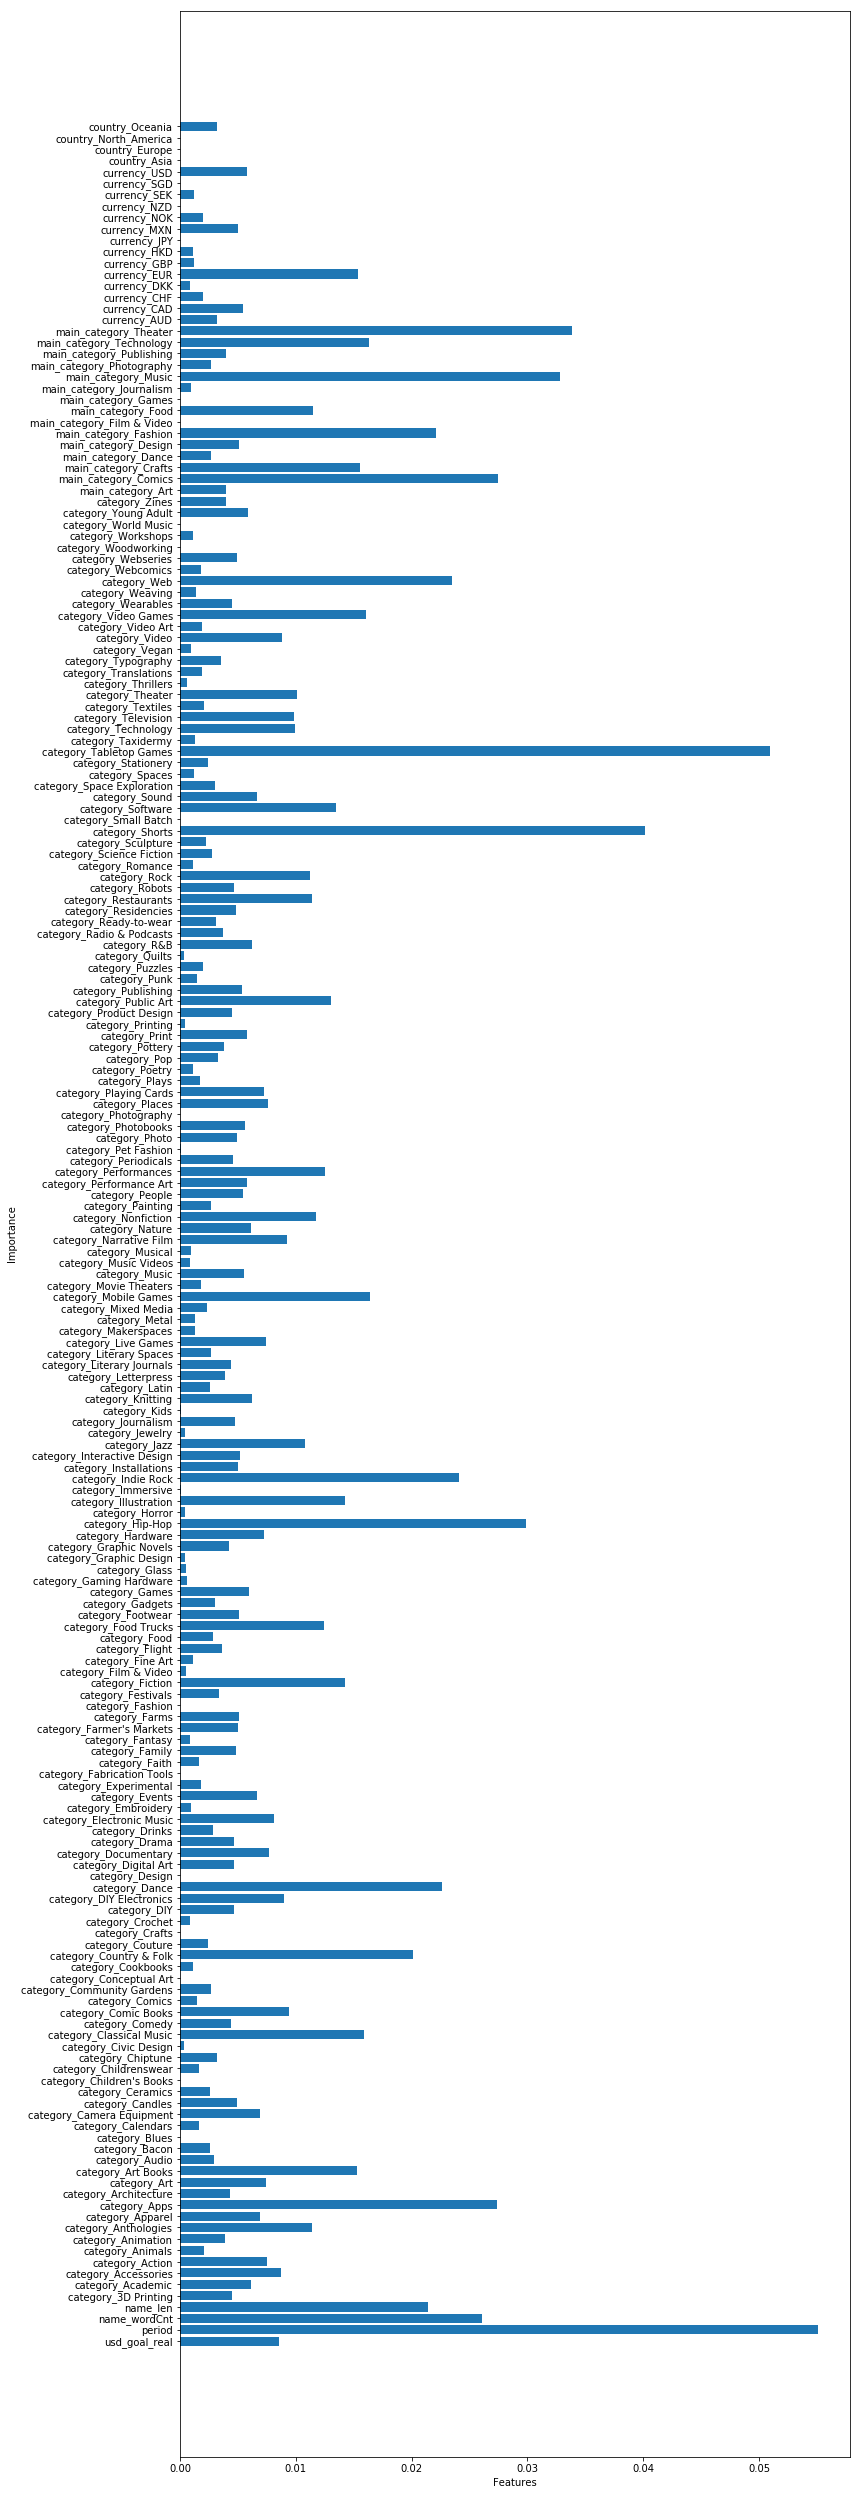

In [63]:
# 係数を棒グラフで表示
print(np.arange(0, len(abs_coef)))
fig = plt.figure(figsize=(12, 45))
plt.barh(np.arange(0, len(abs_coef)), abs_coef, tick_label=df_kp3.drop("state",axis=1).columns.values)
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

## ③-3 ロジスティック回帰で学習
- (5) 特徴選択後の説明変数を使用してロジスティック回帰で学習する
- ハイパーパラメータの値を変更して精度が良いモデルを探す
- ロジスティック回帰、ランダムフォレスト、アダブーストの中でaccuracyが一番高いモデルを見つける

In [64]:
# (5)学習用データを使ってロジスティック回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.372%
テスト用データ識別精度（accuracy）= 67.180%


In [65]:
# (5)学習用データを使ってロジスティック回帰モデルを学習　alpha=0.0001
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.0001)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.282%
テスト用データ識別精度（accuracy）= 67.069%


In [66]:
# (5)学習用データを使ってロジスティック回帰モデルを学習　alpha=0.001
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.001)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 66.794%
テスト用データ識別精度（accuracy）= 66.633%


In [67]:
# (5)学習用データを使ってロジスティック回帰モデルを学習　alpha=0.00001
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.00001)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 66.776%
テスト用データ識別精度（accuracy）= 66.766%


In [68]:
# (5)学習用データを使ってロジスティック回帰モデルを学習
clf = SGDClassifier(loss='log', penalty='none', max_iter=100000, fit_intercept=True, random_state=1234, tol=1e-3)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.372%
テスト用データ識別精度（accuracy）= 67.180%


In [69]:
# (5)学習用データを使ってロジスティック回帰モデルを学習　alpha=0.005
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.005)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 65.895%
テスト用データ識別精度（accuracy）= 65.938%


In [70]:
# (5)学習用データを使ってロジスティック回帰モデルを学習　alpha=0.0005
clf = SGDClassifier(loss='log', penalty='l1', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-3, alpha=0.0005)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.056%
テスト用データ識別精度（accuracy）= 66.990%


- ロジスティック回帰のテスト用データのaccuracyは 67.180% が最大になった。
- Day2課題作成時のaccuracy 65.193% と比較して、accuracyが 1.987% 上がった。
- 特徴選択をしているため、ロジスティック回帰のパラメータでpenalty='l1'を指定すると精度が下がった。特徴選択をした場合、penalty='none'の方が良い？

## ③-3 ランダムフォレストで学習
- (5) 特徴選択後の説明変数を使用してランダムフォレストで学習する
- ロジスティック回帰、ランダムフォレスト、アダブーストの中でaccuracyが一番高いモデルを見つける
- ロジスティクス回帰よりも精度が良かったため、ハイパーパラメータを変更して一番良い精度を見つける

In [71]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=20, criterion="gini",
                             min_samples_leaf=20, min_samples_split=20, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.851%
テスト用データ識別精度（accuracy）= 67.494%


In [72]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, criterion="gini",
                             min_samples_leaf=20, min_samples_split=20, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.921%
テスト用データ識別精度（accuracy）= 67.548%


In [73]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=20, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.841%
テスト用データ識別精度（accuracy）= 67.652%


In [74]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=30, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 70.809%
テスト用データ識別精度（accuracy）= 68.248%


In [75]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=35, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 71.549%
テスト用データ識別精度（accuracy）= 68.459%


In [76]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=40, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.175%
テスト用データ識別精度（accuracy）= 68.474%


In [77]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.869%
テスト用データ識別精度（accuracy）= 68.602%


In [78]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=70, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 73.299%
テスト用データ識別精度（accuracy）= 68.570%


In [79]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=60, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 73.087%
テスト用データ識別精度（accuracy）= 68.599%


In [80]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=55, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.824%
テスト用データ識別精度（accuracy）= 68.552%


In [81]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=52, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.858%
テスト用データ識別精度（accuracy）= 68.545%


In [82]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=51, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.888%
テスト用データ識別精度（accuracy）= 68.602%


In [83]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=500, max_depth=50, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.892%
テスト用データ識別精度（accuracy）= 68.593%


In [84]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=200, max_depth=50, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.873%
テスト用データ識別精度（accuracy）= 68.603%


In [85]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=50, criterion="gini",
                             min_samples_leaf=3, min_samples_split=3, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 76.589%
テスト用データ識別精度（accuracy）= 68.474%


In [86]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=100, max_depth=None, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 73.299%
テスト用データ識別精度（accuracy）= 68.516%


In [87]:
#RandomForestClassifier＝ランダムフォレスト
#n_estimators＝決定木の数。n_estimators=10 決定木を10本作る。通常は100～1000本ぐらい。数が多い方が汎化性能が良くなる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = RandomForestClassifier(n_estimators=1000, max_depth=50, criterion="gini",
                             min_samples_leaf=5, min_samples_split=5, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 72.870%
テスト用データ識別精度（accuracy）= 68.605%


- ランダムフォレストのテスト用データのaccuracyは 68.605% が最大になった。
- Day2課題作成時のaccuracy 65.193% と比較して、accuracyが 3.412% 上がった。
- Day3のロジスティック回帰の 67.180% と比較して、accuracyが 1.425% 上がった。
- ランダムフォレストのモデルの場合、学習用データのaccuracy 72.870% とテスト用データのaccuracy 68.605% で差があり、過学習ぎみと思う。
- 処理時間はロジスティック回帰は数分で終わったが、ランダムフォレストはn_estimatorsを1000でモデルを作成したため数十分かかった。決定木をたくさん作るため、処理時間が長かった。

## ③-3 アダブーストで学習
- (5) 特徴選択後の説明変数を使用してアダブーストで学習する
- ハイパーパラメータの値を変更して精度が良いモデルを探す
- ロジスティック回帰、ランダムフォレスト、アダブーストの中でaccuracyが一番高いモデルを見つける

In [88]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=20,
                                                                                 min_samples_leaf=2,
                                                                                 min_samples_split=2, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=100, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 98.095%
テスト用データ識別精度（accuracy）= 62.353%


- アダブーストは木（n_estimators）が多いと過学習になる。
- 木（n_estimators）を100にしたため、学習の識別精度 > テストの識別精度 で過学習になった。
- 木（n_estimators）を減らして学習する。

In [89]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=26,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 82.427%
テスト用データ識別精度（accuracy）= 63.301%


In [90]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 70.124%
テスト用データ識別精度（accuracy）= 67.608%


In [91]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=10, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 67.999%
テスト用データ識別精度（accuracy）= 67.663%


In [92]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=12, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.159%
テスト用データ識別精度（accuracy）= 67.931%


In [93]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=13, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.228%
テスト用データ識別精度（accuracy）= 68.058%


In [94]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=5,
                                                                                 min_samples_split=5, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=14, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.283%
テスト用データ識別精度（accuracy）= 68.041%


In [97]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=4,
                                                                                 min_samples_split=4, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=13, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.226%
テスト用データ識別精度（accuracy）= 68.071%


In [98]:
#AdaBoostClassifier＝アダブースト
#DecisionTreeClassifier=決定木。この場合は決定木を指定。モデルは何でもよいから、モデルを指定する
#他に、線形回帰モデル(LinearRegression)、ロジスティクス回帰(LogisticRegression,SGDClassifier)を指定してもOK。
#n_estimators＝決定木の数。アダブーストは木（n_estimators）が多いと過学習になる。
#max_depth＝木の最大の深さ。Noneの場合、すべてのリーフが純粋になるまで、またはすべてのリーフに含まれるサンプルがmin_samples_split未満になるまで、ノードが展開されます
#criterion＝不純度を指定。ジニ係数を利用する場合は「gini」。エントロピーは「entropy」。
#min_samples_leaf＝1つのサンプルが属する葉の数の最小値。枝に存在するデータの数の最低数を設定。
#min_samples_split＝サンプルを枝に分割する数の際の枝の数の最小値。枝を張るときにどれだけデータがあれば枝を張るのか。
#random_state＝乱数のシードを指定
clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=5,
                                                                                 min_samples_leaf=3,
                                                                                 min_samples_split=3, 
                                                                                 random_state=1234,
                                                                                 criterion="gini"),
                                           n_estimators=13, random_state=1234)
# 学習する
clf.fit(X_train_sel, y_train)
# 識別精度
print('学習用データの識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_train_sel, y_train)))
print('テスト用データ識別精度（accuracy）= {:.3f}%'.format(100 * clf.score(X_test_sel, y_test)))

学習用データの識別精度（accuracy）= 68.226%
テスト用データ識別精度（accuracy）= 68.055%


- アダブーストのテスト用データのaccuracyは 68.071% が最大になった。
- Day2課題作成時のaccuracy 65.193% と比較して、accuracyが 2.878% 上がった。
- Day3のロジスティック回帰の 67.180% と比較して、accuracyが 0.891% 上がった。
- Day3のランダムフォレストの 68.605% と比較して、accuracyが 0.534% 下がった。
- アダブーストのモデルの場合、学習用データのaccuracy 68.226% とテスト用データのaccuracy 68.071% で差があまりなく、学習がうまくいったと思われる。
- 処理時間はアダブーストは過学習を抑えるために決定木をあまり作らないため、ランダムフォレストよりも処理時間が短く、ランダムフォレストよりは劣るが同程度の精度のモデルが作成できた。

## まとめ

|accuracyの順位|モデル|学習|テスト|
| :--- | :--- | :--- | :--- |
|1|ランダムフォレスト|72.870%|68.605%|
|2|アダブースト|68.226%|68.071%|
|3|ロジスティック回帰|67.372%|67.180%|

- テスト用データのaccuracyが一番高いモデルは「ランダムフォレスト」で 68.605% になった。
- Day2時のaccuracy 65.193% と比較して、accuracyが 3.412% 上がった。

## 感想
- ハイパーパラメータをいろいろ変更して精度が高くなるモデルを見つけるのが大変だった。
- 試しにダミー変数に変換したcategoryを説明変数に追加して普通のロジスティック回帰をしてみると、accuracyが約3%上がった。categoryはデータ数が多く、同じような意味のmain_categoryがあるため、なくても大差ないと思ってDay2まではcategoryを説明変数から除外していた。categoryの特徴量をグラフで描画すると成功率のばらつきがmain_categoryよりも大きくなっていることが分かった。データの特徴量をとらえることはモデルの精度にも繋がることがよく分かった。
- グラフを描いてデータの特徴を考えることが苦手なため、今後、様々なグラフを描いてデータの特徴をつかめるようにしたい。
- また、他の方のプログラムを見て、特徴量の出し方やグラフの描画がとても参考になった。